# European Soccer

In [1]:
import collections
import csv
import numpy as np
import pandas as pd
import sqlite3 as lite

from sklearn.preprocessing import normalize

In [101]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Extracting Data
dataset available at: https://www.kaggle.com/hugomathien/soccer/data

complement available at: https://www.kaggle.com/jiezi2004/soccer

In [311]:
con = lite.connect('database.sqlite')
df = pd.read_sql_query('select * from match', con)
players = pd.read_sql_query('select * from player_Attributes', con)

In [312]:
df.sort_values(by='date', inplace=True, ascending=False)
players.sort_values(by='date', inplace=True, ascending=False)

## 2. Modifying the tables to take usable values

In [313]:
"""
maps all the players attributes to floats between 0. and 1.

the attribute 'preffered_foot' is mapped to [1., 0.] or [0., 1.]

values 'low', 'medium' and 'high' are mapped to 0., 0.5 and 1.
"""
def map_attributes(df):
    df['other_foot'] = df['preferred_foot'].copy()
    
    val1 = df.loc[:, 'preferred_foot'].map(lambda x: 100. - 100. * (x == 'left'))
    val2 = df.loc[:, 'preferred_foot'].map(lambda x: 0. + 100. * (x == 'left'))
    val3 = df.loc[:,'attacking_work_rate':'defensive_work_rate'].applymap(lambda x: 0. + 50.*(x=='medium') + 100.*(x=='high'))
    
    df.loc[:, 'other_foot'] = val1
    df.loc[:, 'preferred_foot'] = val2
    df.loc[:,'attacking_work_rate':'defensive_work_rate'] = val3
   
    df.loc[:, 'overall_rating':] = df.loc[:, 'overall_rating':].applymap(lambda x: x/100.)
    
    return df

In [314]:
player_attributes = map_attributes(players)

In [315]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,other_foot
95620,95621,208127,307224,2016-07-07 00:00:00,0.64,0.68,0.0,0.5,0.0,0.44,...,0.65,0.22,0.22,0.25,0.12,0.12,0.07,0.11,0.12,1.0
57229,57230,197948,184521,2016-07-07 00:00:00,0.73,0.77,0.0,0.5,1.0,0.51,...,0.43,0.74,0.75,0.69,0.11,0.15,0.15,0.12,0.07,1.0
181048,181049,221274,512726,2016-07-07 00:00:00,0.63,0.72,0.0,0.5,0.5,0.51,...,0.59,0.15,0.16,0.12,0.11,0.12,0.12,0.12,0.07,1.0
178639,178640,216437,450002,2016-07-07 00:00:00,0.74,0.82,0.0,0.5,0.5,0.34,...,0.45,0.76,0.78,0.74,0.15,0.11,0.11,0.10,0.11,1.0
153508,153509,172555,45400,2016-07-07 00:00:00,0.68,0.70,0.0,0.5,0.0,0.33,...,0.66,0.23,0.17,0.23,0.13,0.11,0.06,0.09,0.14,1.0


In [316]:
mean_attributes = player_attributes.loc[:, 'overall_rating':].mean()

In [317]:
mean_attributes

overall_rating         0.686000
potential              0.734604
preferred_foot         0.243143
attacking_work_rate    0.572666
defensive_work_rate    0.502582
crossing               0.550869
finishing              0.499211
heading_accuracy       0.572660
short_passing          0.624297
volleys                0.494684
dribbling              0.591752
curve                  0.529657
free_kick_accuracy     0.493810
long_passing           0.570699
ball_control           0.633889
acceleration           0.676594
sprint_speed           0.680512
agility                0.659709
reactions              0.661037
balance                0.651895
shot_power             0.618084
jumping                0.669690
stamina                0.670385
strength               0.674245
long_shots             0.533394
aggression             0.609480
interceptions          0.520093
positioning            0.557865
vision                 0.578735
penalties              0.550040
marking                0.467722
standing

In [334]:
mat_mean_attributes = mean_attributes.as_matrix()

## 3. Extracting desired features

### 3.1 Match features

In [318]:
"""
assumes that df is sorted by dates in decreasing order

returns the last 'n_matchs' matchs of team 'team_id' anterior to 'date'

location can be 'home', 'away' or None (which means indifferent here)
"""
def last_matchs(df, team_id, date, n_matchs, location = None):
    if location == 'home':
        df = df[df['home_team_api_id']==team_id]
    if location == 'away':
        df = df[df['away_team_api_id']==team_id]
    else:
        df = pd.concat([df[df['home_team_api_id']==team_id],df[df['away_team_api_id']==team_id]])
    
    df = df[df['date'] < date]
    #df.sort_values(by='date', ascending=False, inplace=True)
    df.reset_index(inplace=True)

    n_matchs = min(n_matchs, len(dum_df)) - 1
    
    return df.loc[0:n_matchs]

In [319]:
dum = last_matchs(df, 9987, '2017-12-30', 5, 'away')

In [320]:
dum

,index,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1657,1658,1,1,2015/2016,29,2016-03-05 00:00:00,1980049,9985,9987,...,NaN,2.00,3.50,3.60,NaN,NaN,NaN,NaN,NaN,NaN
1,1645,1646,1,1,2015/2016,27,2016-02-20 00:00:00,1980037,9994,9987,...,NaN,2.90,3.25,2.45,NaN,NaN,NaN,NaN,NaN,NaN
2,1628,1629,1,1,2015/2016,25,2016-02-06 00:00:00,1980020,274581,9987,...,NaN,3.20,3.30,2.25,NaN,NaN,NaN,NaN,NaN,NaN
3,1610,1611,1,1,2015/2016,23,2016-01-23 00:00:00,1980002,8203,9987,...,NaN,2.70,3.25,2.63,NaN,NaN,NaN,NaN,NaN,NaN
4,1597,1598,1,1,2015/2016,21,2015-12-26 00:00:00,1979989,9986,9987,...,NaN,2.55,3.30,2.75,NaN,NaN,NaN,NaN,NaN,NaN


In [321]:
def match_features(df):
    df = df.loc[:, 'home_team_goal':'away_team_goal']
    
    return df.as_matrix().reshape(-1)

In [322]:
match_features(dum)

array([2, 1, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

### 3.2 Team features

In [335]:
"""
assumes that the table of players attributes is sorted in decreasing order

returns the most recent attributes for player 'player_id' up to date 'date'.
"""
def player_features(df, player_id, date):    
    df = df[df['player_api_id']==player_id]
    
    df = df[df['date'] <= date]
    #df.sort_values(by='date', ascending=False, inplace=True)
    df.reset_index(inplace=True)
    
    if 0 in df.index:
        res = df.loc[0,'overall_rating':].as_matrix()
    else:
        res = mat_mean_attributes
        
    res[pd.isnull(res)] = mat_mean_attributes[pd.isnull(res)]
        
    return res

In [324]:
player_features(player_attributes, 505942, '2017-01-01')

array([0.67000000000000004, 0.70999999999999996, 0.0, 0.5, 0.5,
       0.48999999999999999, 0.44, 0.70999999999999996, 0.60999999999999999,
       0.44, 0.51000000000000001, 0.45000000000000001, 0.39000000000000001,
       0.64000000000000001, 0.48999999999999999, 0.59999999999999998,
       0.64000000000000001, 0.58999999999999997, 0.46999999999999997,
       0.65000000000000002, 0.55000000000000004, 0.57999999999999996,
       0.54000000000000004, 0.76000000000000001, 0.34999999999999998,
       0.70999999999999996, 0.69999999999999996, 0.45000000000000001,
       0.54000000000000004, 0.47999999999999998, 0.65000000000000002,
       0.68999999999999995, 0.68999999999999995, 0.059999999999999998,
       0.11, 0.10000000000000001, 0.080000000000000002,
       0.080000000000000002, 1.0], dtype=object)

In [325]:
"""
Y donne la position de but (1) à rond central (11)
X donne la position de gauche (1) à droite (9)
"""
def team_features(df_row, attributes, location = 'home'):
        date = df_row['date']
        ids = df_row[location+'_player_1':location+'_player_11'].as_matrix()
        X = df_row[location+'_player_X1':location+'_player_X11'].as_matrix()
        Y = df_row[location+'_player_Y1':location+'_player_Y11'].as_matrix()
        
        positions = {i : (ids[i],X[i],Y[i]) for i in range(11)}
        positions = sorted(positions.items(), key=lambda x: (x[1][2], x[1][1]))

        res = []
        for i, val in positions:
            player = val[0]
            res += list(player_features(attributes, player, date))
            
        return res

In [326]:
team_features(df.loc[0], player_attributes)

[0.6860001528868207,
 0.73460353168577575,
 0.24314320190457556,
 0.5726662970572568,
 0.50258183043624782,
 0.55086883401951947,
 0.49921077633752309,
 0.57266023085910611,
 0.62429672057749153,
 0.49468435715665282,
 0.59175153705871397,
 0.5296567456486182,
 0.49380950300859688,
 0.57069880202246603,
 0.63388878575092922,
 0.67659357220076388,
 0.68051244389592691,
 0.65970909993650595,
 0.66103706413598828,
 0.65189496041702821,
 0.61808427340533889,
 0.66969045320386211,
 0.67038543862136668,
 0.67424528507930381,
 0.53339430605759774,
 0.60948045778688942,
 0.52009271494251241,
 0.55786504461018838,
 0.57873549775189137,
 0.55003985978093739,
 0.46772242303790207,
 0.50351257494187995,
 0.48001461947976048,
 0.14704393312296304,
 0.16063611842181294,
 0.20998361926810902,
 0.16132154284657929,
 0.16441438883493761,
 0.7568567980954245,
 0.6860001528868207,
 0.73460353168577575,
 0.24314320190457556,
 0.5726662970572568,
 0.50258183043624782,
 0.55086883401951947,
 0.4992107763375

### 3.3 Bookmakers features

In [327]:
def avg_val(s):
    return 0.46 * (s[-1] == 'H') + 0.29 * (s[-1] == 'D') + 0.25 * (s[-1] == 'A')

def BM_features(row):
    row = row.loc['B365H':'BSA']
    row = row.map(lambda x: 1/x)

    values = {key: avg_val(key) for key in row.index}
    row.fillna(value=values, inplace=True)
    
    bm = (row.as_matrix()).reshape(-1, 10, 3)
    for i in range(len(bm)):
        bm[i] = normalize(bm[i], axis = 1, norm = 'l1')
    
    return bm.reshape(-1)

In [328]:
BM_features(df.loc[0])

array([ 0.53913485,  0.2743245 ,  0.18654066,  0.5157152 ,  0.26940346,
        0.21488133,  0.47467684,  0.27442255,  0.25090061,  0.49371634,
        0.26929982,  0.23698384,  0.46      ,  0.29      ,  0.25      ,
        0.52417461,  0.27002935,  0.20579604,  0.48762468,  0.2807536 ,
        0.23162172,  0.53996824,  0.26204341,  0.19798835,  0.50183362,
        0.27485041,  0.22331596,  0.52063585,  0.26491177,  0.21445238])

### 3.4 Concatenation

In [330]:
def all_features(df_matchs, df_players, n_matchs):
    features = []
    ground_truth = []
    
    for row in df_matchs.iterrows():
        i = row[0]
        row = row[1]
        
        if i%100 == 99:
            print('.', sep=' ', end='', flush=True)
        if i%1000 == 999:
            print(i+1)
            
        home_team_id = row['home_team_api_id']
        away_team_id = row['away_team_api_id']
        date = row['date']
        
        #matchs features
        home_team_last_matchs_home = match_features(last_matchs(df, home_team_id, date, n_matchs, location = 'home'))
        home_team_last_matchs_away = match_features(last_matchs(df, home_team_id, date, n_matchs, location = 'away'))
        away_team_last_matchs_home = match_features(last_matchs(df, away_team_id, date, n_matchs, location = 'home'))
        away_team_last_matchs_away = match_features(last_matchs(df, away_team_id, date, n_matchs, location = 'away'))
        
        matchs_feat = np.zeros(4 * 2 * n_matchs)
        
        matchs_feat[0 * n_matchs : 0 * n_matchs+len(home_team_last_matchs_home)] += home_team_last_matchs_home
        matchs_feat[2 * n_matchs : 2 * n_matchs+len(home_team_last_matchs_away)] += home_team_last_matchs_away
        matchs_feat[4 * n_matchs : 4 * n_matchs+len(away_team_last_matchs_home)] += away_team_last_matchs_home
        matchs_feat[6 * n_matchs : 6 * n_matchs+len(away_team_last_matchs_away)] += away_team_last_matchs_away
        
        #team features
        home_team_feat = team_features(row, df_players, location = 'home')
        away_team_feat = team_features(row, df_players, location = 'away')
        
        team_feat = np.array(home_team_feat + away_team_feat)
        
        if np.count_nonzero(np.isnan(team_feat)) > 0:
            return team_feat
        
        #bookmakers features
        bm_feat = BM_features(row)
        
        #concatenation
        all_feat = np.concatenate((matchs_feat, team_feat, bm_feat))
        gt = 1 + np.sign(row['home_team_goal'] - row['away_team_goal'])
        
        features.append(all_feat)
        ground_truth.append(gt)
        
    return features, ground_truth

In [ ]:
all_features(df, player_attributes, 10)

.............

In [210]:
import pickle

In [272]:
pickle.dump(feat, open('new_features.p', 'wb'))

In [215]:
pickle.dump(GT, open('ground_truth.p', 'wb'))

In [246]:
len(features)

25979

In [217]:
from sklearn.decomposition import PCA

In [220]:
pca = PCA()

In [224]:
feat = np.array(features)

In [254]:
mean_feat = np.nanmean(feat, axis = 0)

In [255]:
mean_feat.shape

(968,)

In [256]:
extended_mean = np.array([mean_feat for i in range(len(feat))])

In [258]:
nan_loc = np.argwhere(np.isnan(feat))

In [259]:
feat[nan_loc] = extended_mean[nan_loc]

In [262]:
pca.fit(feat)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<Container object of 968 artists>

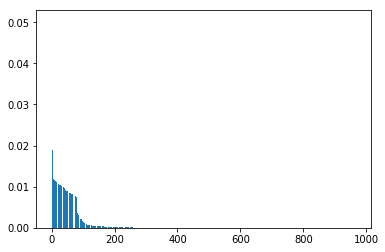

In [265]:
plt.bar(np.arange(968), pca.explained_variance_ratio_)

In [266]:
X = pca.transform(feat)

In [271]:
cut = int(0.8 * len(X))
X_train, X_test = X[:cut,:300], X[cut:,:300]
y_train, y_test = GT[:cut], GT[cut:]

In [269]:
from sklearn.ensemble import RandomForestClassifier

In [277]:
rf = RandomForestClassifier(class_weight = {0:0.25, 1:0.29, 2:  0.46})

In [278]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.25, 1: 0.29, 2: 0.46}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [279]:
rf.score(X_test, y_test)

0.43802925327174752